# Board-Game 游戏分析

## 一、背景

 BoardGameGeek是一个棋盘游戏论坛，该论坛有各类棋盘等游戏介绍和玩家评价等信息。
 
 数据源下载自[Kaggle](https://www.kaggle.com/mrpantherson/board-game-data)。

## 二、明确需求

我希望从数据解读以下信息：

1、查看游戏数据中有何特点。

2、游戏排名与哪些变量相关。

## 三、数据预处理

### 3.1 导入数据

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
with open(r'bgg_db_1806.csv', encoding='UTF-8') as f:
    df = pd.read_csv(f)


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 20 columns):
rank           4999 non-null int64
bgg_url        4999 non-null object
game_id        4999 non-null int64
names          4999 non-null object
min_players    4999 non-null int64
max_players    4999 non-null int64
avg_time       4999 non-null int64
min_time       4999 non-null int64
max_time       4999 non-null int64
year           4999 non-null int64
avg_rating     4999 non-null float64
geek_rating    4999 non-null float64
num_votes      4999 non-null int64
image_url      4998 non-null object
age            4999 non-null int64
mechanic       4999 non-null object
owned          4999 non-null int64
category       4999 non-null object
designer       4999 non-null object
weight         4999 non-null float64
dtypes: float64(3), int64(11), object(6)
memory usage: 781.2+ KB


查看数据结构

In [4]:
df.head()


,rank,bgg_url,game_id,names,min_players,max_players,avg_time,min_time,max_time,year,avg_rating,geek_rating,num_votes,image_url,age,mechanic,owned,category,designer,weight
0,1,https://boardgamegeek.com/boardgame/174430/glo...,174430,Gloomhaven,1,4,120,60,120,2017,8.98893,8.61858,15376,https://cf.geekdo-images.com/original/img/lDN3...,12,"Action / Movement Programming, Co-operative Pl...",25928,"Adventure, Exploration, Fantasy, Fighting, Min...",Isaac Childres,3.7543
1,2,https://boardgamegeek.com/boardgame/161936/pan...,161936,Pandemic Legacy: Season 1,2,4,60,60,60,2015,8.66140,8.50163,26063,https://cf.geekdo-images.com/original/img/P_Sw...,13,"Action Point Allowance System, Co-operative Pl...",41605,"Environmental, Medical","Rob Daviau, Matt Leacock",2.8210
2,3,https://boardgamegeek.com/boardgame/182028/thr...,182028,Through the Ages: A New Story of Civilization,2,4,240,180,240,2015,8.60673,8.30183,12352,https://cf.geekdo-images.com/original/img/1d2h...,14,"Action Point Allowance System, Auction/Bidding...",15848,"Card Game, Civilization, Economic",Vlaada Chvátil,4.3678
3,4,https://boardgamegeek.com/boardgame/167791/ter...,167791,Terraforming Mars,1,5,120,120,120,2016,8.38461,8.19914,26004,https://cf.geekdo-images.com/original/img/o8z_...,12,"Card Drafting, Hand Management, Set Collection...",33340,"Economic, Environmental, Industry / Manufactur...",Jacob Fryxelius,3.2456
4,5,https://boardgamegeek.com/boardgame/12333/twil...,12333,Twilight Struggle,2,2,180,120,180,2005,8.33954,8.19787,31301,https://cf.geekdo-images.com/original/img/ZPnn...,13,"Area Control / Area Influence, Campaign / Batt...",42952,"Modern Warfare, Political, Wargame","Ananda Gupta, Jason Matthews",3.5518


### 3.2 理解数据

数据集中主要的数据字典对应的含义：  
rank：排名  
game_id：游戏ID  
names：游戏名称  
min_players：最少玩家数量  
max_players：最多玩家数量  
avg_time：平均在线时间  
min_time：最小在线时间  
max_time：最大在线时间  
year：发行年份  
avg_rating：平均评分  
geek_rating：geek评分  
num_votes：票数  
age：最小年龄  
owned：购买人数  
weight：游戏复杂度权重

### 3.3 缺失值处理

In [5]:
df.isnull().sum()


rank           0
bgg_url        0
game_id        0
names          0
min_players    0
max_players    0
avg_time       0
min_time       0
max_time       0
year           0
avg_rating     0
geek_rating    0
num_votes      0
image_url      1
age            0
mechanic       0
owned          0
category       0
designer       0
weight         0
dtype: int64

可以看出除了一个image_url，其他特征没有缺失值（没有缺失值不代表没有异常值），影响不大，本分析无需缺失值进一步处理。

# 四、数据处理与模型构建

### 4.1 最少最多玩家对应的游戏数量

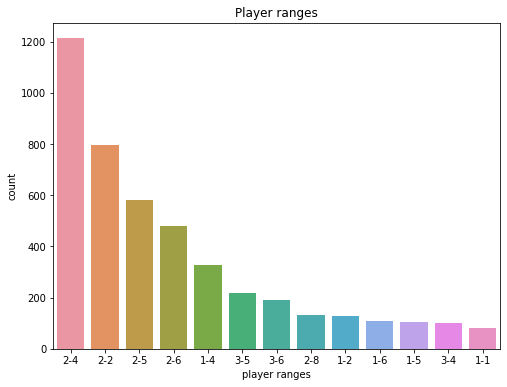

In [6]:
df['player_range'] = df['min_players'].astype(str)+'-'+df['max_players'].astype(str)
range_count = df['player_range'].value_counts()
range_count = range_count[range_count>50] #减少罕见事件
plt.subplots(figsize=(8, 6))
ax = sns.barplot(x=range_count.index, y=range_count)
plt.title('Player ranges')
ax.set(xlabel='player ranges', ylabel='count')
plt.show()


可见，2-4人的游戏最受欢迎，其次是2-2人，2-5人的游戏。

### 4.2 单次平均游戏时间与游戏数量

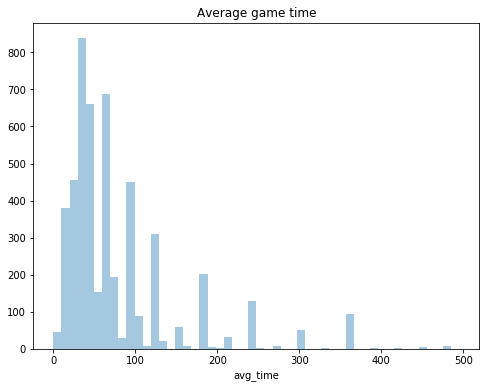

In [7]:
# 单次平均游戏时间
df['avg_time'] = (df['min_time']+df['max_time'])/2
avgtime_df = df[df['avg_time'] < 500 ]
plt.subplots(figsize=(8,6))
sns.distplot(avgtime_df['avg_time'], kde=False)
plt.title('Average game time')
plt.show()


很明显单次游戏时间在30分钟-60分钟是最受欢迎的游戏时间。

### 4.3 最小适用年龄与游戏数量

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


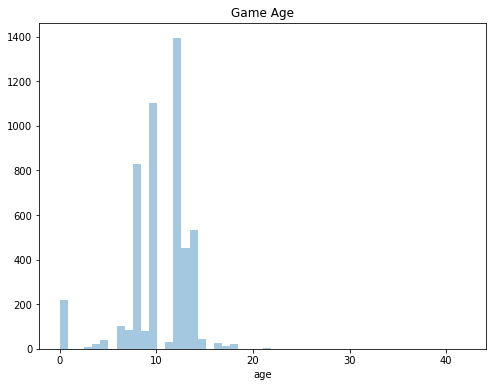

In [8]:
# 最小适用年龄
age_df = df['age'].convert_objects(convert_numeric=True)
age_df = age_df.dropna()
plt.subplots(figsize=(8,6))
sns.distplot(age_df, kde=False)
plt.title('Game Age')
plt.show()


从图可以看出年龄在12岁和10岁有明显的峰值，游戏最小适用年龄主要分布在8岁和14岁之间。

### 4.4 游戏排名和各因素的相关性分析

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


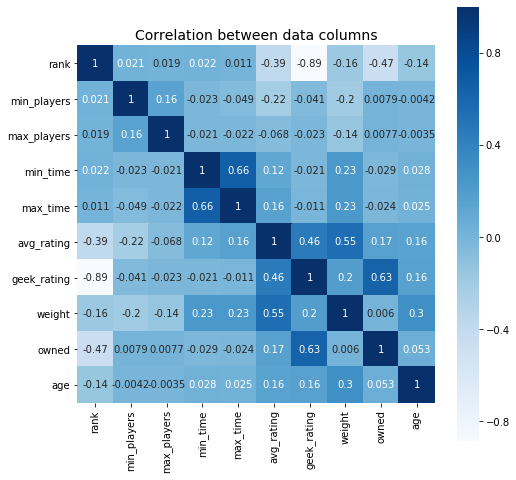

In [9]:
cols = ['rank','min_players', 'max_players', 'min_time', 'max_time', 'avg_rating', 'geek_rating', 'weight', 'owned', 'age']
df2=df[cols].convert_objects(convert_numeric=True)
dfData = df2.corr()
plt.subplots(figsize=(8, 8))
sns.heatmap(dfData, annot=True, vmax=1, square=True, cmap="Blues")
plt.title('Correlation between data columns', fontsize=14)
plt.show()


可以看出排名rank主要与购买数量、平均评分有较大的负相关性，这很容易理解。  

排名与权重关联较小。常识告诉我们权重和排名应该是有一定关联的。  

接下来所以重点分析购买者数量、平均评分、权重与排名更深入的关系。  


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


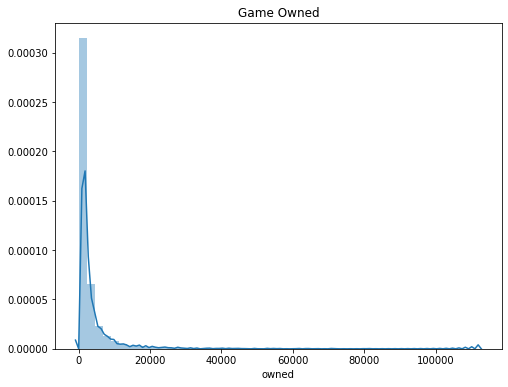

In [10]:
# 先对购买者数量进行分析
owned_df = df['owned'].convert_objects(convert_numeric=True)
owned_df = owned_df.dropna()
plt.subplots(figsize=(8,6))
sns.distplot(owned_df)
plt.title('Game Owned')
plt.show()


可以看出购买者数量分布有很明显的长尾效应的，这符合常理。

进一步查看购买者数量与具体各名次段的分布。

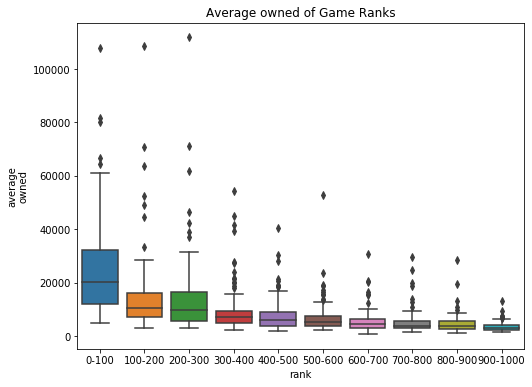

In [11]:
# 分析购买者与排名的关系，分段进行箱体展示
num_box = 10
plt.subplots(figsize=(8,6))
start_vals = range(0, (num_box*100), 100)
end_vals = [i+100 for i in start_vals]
owned = [owned_df[start:end] for start, end in zip(start_vals, end_vals)]
ax = sns.boxplot(data=owned)
ax.set(xlabel='rank', ylabel='average\nowned', title='Average owned of Game Ranks', xticklabels=['{}-{}'.format(i,j) for i,j in zip(start_vals,end_vals)])
plt.show()


从以上分析可以很明显看出购买者数量与排名有明显的负相关，购买者数量越多，对应的排名越前面。

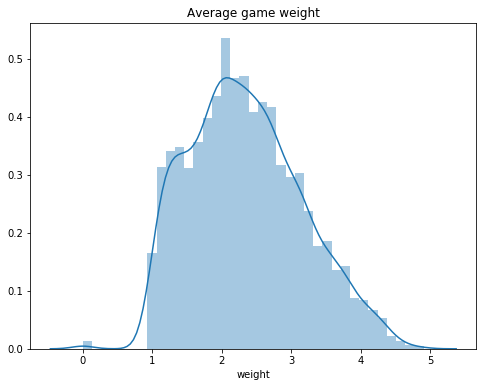

In [12]:
# 平均游戏复杂度权重分布情况
plt.subplots(figsize=(8,6))
sns.distplot(df['weight'])
plt.title('Average game weight')
plt.show()


可以看出权重是比较正态分布的，这符合常理。

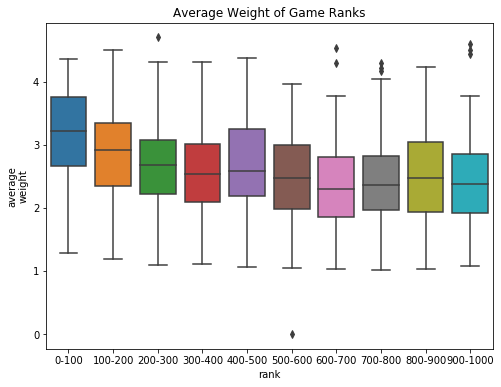

In [13]:
# 看看较高的权重是否与较高的排名相关
plt.subplots(figsize=(8,6))
num_box = 10
start_vals = range(0, (num_box*100), 100)
end_vals = [i+100 for i in start_vals]
weight = [df['weight'][start:end] for start, end in zip(start_vals,end_vals)]
ax = sns.boxplot(data=weight)
ax.set(xlabel='rank',ylabel='average\nweight', title='Average Weight of Game Ranks', xticklabels=['{}-{}'.format(i,j) for i,j in zip(start_vals, end_vals)])
plt.show()


图中可以看出，权重越高排名越靠前的结论不太明显。

因此我们接下去看评分是不是与权重有关系。

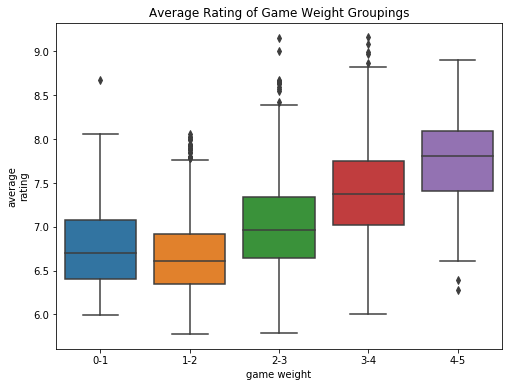

In [14]:
# 看看评分是否与游戏权重有关
plt.subplots(figsize=(8,6))
bins = [-1,1,2,3,4,5]
df['weight_cat'] = pd.cut(df['weight'], bins=bins, labels=bins[1:])
weight = [df[df['weight_cat'] == i]['avg_rating'] for i in range(1,6)]
ax = sns.boxplot(data=weight)
ax.set(xlabel='game weight', ylabel='average\nrating', title='Average Rating of Game Weight Groupings', xticklabels=['0-1', '1-2', '2-3', '3-4', '4-5'])
plt.show()


我们发现，权重越高的游戏，评分也越高。

我们再来看看评分与排名的关系。

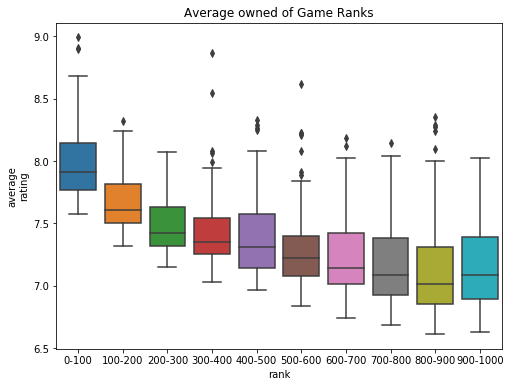

In [15]:
# 分析评分与排名的关系
num_box = 10
plt.subplots(figsize=(8,6))
start_vals = range(0, (num_box*100), 100)
end_vals = [i+100 for i in start_vals]
rating = [df['avg_rating'][start:end] for start, end in zip(start_vals, end_vals)]
ax = sns.boxplot(data=rating)
ax.set(xlabel='rank', ylabel='average\nrating', title='Average owned of Game Ranks', xticklabels=['{}-{}'.format(i,j) for i,j in zip(start_vals,end_vals)])
plt.show()


我们可以看到，平均评分与排名有负相关，平均评分越高，对应的排名越前面。

因此，权重对于排名，有间接的关系。

## 五、结论

通过以上棋盘游戏的分析，我们得到以下结论：

1、2-4人的游戏最受欢迎，其次是2-2人，2-5人的游戏；

2、最受欢迎的游戏，平均单次游戏时间在30分钟-60分钟；

3、游戏最小适用年龄主要分布在8岁和14岁之间，其中最小适用年龄在12岁和10岁的游戏，数量是最多的；

4、游戏的排名与购买者数量、平均评分有明显负相关，购买者数量越多、平均评分越高，对应的排名越靠前；

5、总体上游戏的权重与其排名没有明显相关性，但权重越高的游戏，平均评分也会越高，对排名有间接的关系。

由于对数据对应的具体的业务没有更深入掌握，对于结论不能结合具体业务进行分析，是本文的最大不足。